In [14]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, Reshape, AveragePooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from tensorflow.keras.optimizers import Adam, RMSprop
from shutil import rmtree
from itertools import cycle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sb
import tensorflow as tf
import matplotlib.cm as cm
import re

# Project variables

In [15]:
m_name = "vgg16_4_classes_2"
p_dir = os.path.join("../img models", m_name)

In [16]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [17]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [18]:
create_dir(p_dir)
clear_dir(p_dir)

# Read and transform scraped dataframes

In [19]:
fp = "../scraped data"

channels = pd.read_pickle(os.path.join(fp, "channels.pkl"))
videos = pd.read_pickle(os.path.join(fp, "videos.pkl"))

In [20]:
def transform_channels(df: pd.DataFrame) -> pd.DataFrame:
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type into int64
    fields = ["video_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["subscriber_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    # Add of channel in months
    df["age_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
        
    # Drop unnecessary fields
    df.drop(columns=["custom_url", "country"] + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    # Remove channels without subscriber_count
    df = df.loc[df.subscriber_count.notnull(), :]
    
    return df

In [21]:
def transform_videos(df: pd.DataFrame) -> pd.DataFrame:    
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type to bool
    fields = ["broadcast"]
    df.loc[:, fields] = df.loc[:, fields].astype("bool")
    
    # Convert field type into int64
    fields = ["category_id"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["comment_count", "dislike_count", "like_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    df["published_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
    df["title_len"] = df.title.str.len()
    
    df.drop(columns=["favorite_count", "broadcast", "audio_language", "comment_count", "category_id"] \
            + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    df = df.loc[df.like_count.notnull() & df.dislike_count.notnull() & df.view_count.notnull(), :]
    
    return df

In [22]:
channels_trans = transform_channels(channels)
videos_trans = transform_videos(videos)
combo = videos_trans.merge(channels_trans[["id", "view_count","published", "age_mth", "subscriber_count",
                                             "video_count"]], 
                           how="inner", left_on="channel_id", right_on="id", suffixes=["_video", "_channel"])
combo["ln_vc_norm"] = np.log(combo.video_count / combo.subscriber_count)

# Define categories

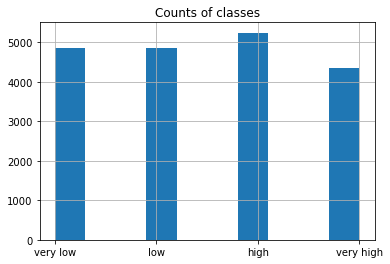

In [23]:
cat_lbl = ["very low", "low", "high", "very high"]
combo.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl), labels=cat_lbl, precision=6)
combo.sort_values(by=["qtl"]).qtl.hist()
plt.title("Counts of classes")
plt.show()

# Split dataset

In [24]:
y = combo.qtl
x = combo.loc[:, [c for c in combo.columns if c != "qtl"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_val.shape[0], x_test.shape[0])

11586 3862 3863


# Build the model

In [25]:
def create_model():
    
    inp = Input(shape=(120, 90, 3))
    
    # Transfer learning layers
    base_model = VGG16(include_top=False, weights="imagenet", input_tensor=inp)
    base_model.trainable = False
    x = base_model.output
    
    x = AveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(len(cat_lbl), activation="softmax")(x)
    
    model = Model(base_model.input, out)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.0005), 
                  metrics=["accuracy"])
    
    return model

In [26]:
model = create_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 90, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 90, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 90, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 45, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 45, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 45, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 22, 128)       0   

# Prepare ImageDataGenerators

In [27]:
def train_generator(X, y, img_dir, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                  rotation_range=15,
#                                  width_shift_range=0.15,
#                                  height_shift_range=0.15,
#                                  zoom_range=0.2,
#                                  horizontal_flip=True,
#                                  dtype=np.float32
                                )
    gen = datagen.flow_from_dataframe(dataframe=combo,
                                      directory=img_dir,
                                      x_col="file_name", 
                                      y_col="qtl",
                                      class_mode="categorical",
                                      color_mode="rgb",
                                      target_size=(120, 90),
                                      shuffle=True,
                                      batch_size=batch_size                                      
                                     )
    return gen

def val_generator(X, y, img_dir, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    gen = datagen.flow_from_dataframe(dataframe=combo,
                                      directory=img_dir,
                                      x_col="file_name", 
                                      y_col="qtl",
                                      class_mode="categorical",
                                      color_mode="rgb",
                                      target_size=(120, 90),
                                      shuffle=True,
                                      batch_size=batch_size                                      
                                     )
    return gen

# Train the model

In [28]:
img_dir = "../images"
batch_size = 64

train_gen = train_generator(x_train, y_train, img_dir, batch_size)
val_gen = val_generator(x_val, y_val, img_dir, batch_size)

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='min')

hist = model.fit(train_gen,
                 epochs=200,
                 validation_data=val_gen,
                 verbose=1,
                 callbacks=[checkpoint, es])

Found 11586 validated image filenames belonging to 4 classes.
Found 3862 validated image filenames belonging to 4 classes.
Epoch 1/200


2021-10-04 19:25:51.937597: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-04 19:25:53.307733: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


182/182 [==============================] - 23s 94ms/step - loss: 1.4361 - accuracy: 0.4972 - val_loss: 0.8962 - val_accuracy: 0.6409

Epoch 00001: val_loss improved from inf to 0.89622, saving model to ../img models/vgg16_4_classes_2/vgg16_4_classes_2


2021-10-04 19:26:15.595132: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../img models/vgg16_4_classes_2/vgg16_4_classes_2/assets
Epoch 2/200
182/182 [==============================] - 15s 83ms/step - loss: 1.1081 - accuracy: 0.5674 - val_loss: 0.8284 - val_accuracy: 0.6665

Epoch 00002: val_loss improved from 0.89622 to 0.82840, saving model to ../img models/vgg16_4_classes_2/vgg16_4_classes_2
INFO:tensorflow:Assets written to: ../img models/vgg16_4_classes_2/vgg16_4_classes_2/assets
Epoch 3/200
182/182 [==============================] - 15s 82ms/step - loss: 1.0065 - accuracy: 0.5918 - val_loss: 0.7951 - val_accuracy: 0.6849

Epoch 00003: val_loss improved from 0.82840 to 0.79508, saving model to ../img models/vgg16_4_classes_2/vgg16_4_classes_2
INFO:tensorflow:Assets written to: ../img models/vgg16_4_classes_2/vgg16_4_classes_2/assets
Epoch 4/200
182/182 [==============================] - 15s 82ms/step - loss: 0.9278 - accuracy: 0.6157 - val_loss: 0.7832 - val_accuracy: 0.6763

Epoch 00004: val_loss improved from 0.7950

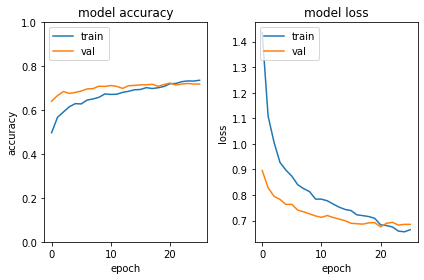

In [29]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
# axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Some sample images per category

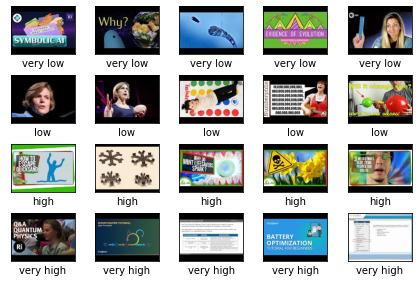

In [30]:
s = combo.loc[combo["id_video"].isin(x_train["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(5, random_state=563))

fig, axs = plt.subplots(len(cat_lbl), 5)
i = 0
for idx, row in s.iterrows():
    img = Image.open(os.path.join(img_dir, "{}.jpg".format(row["id_video"])))
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].xaxis.set_ticklabels([])
    axs[i // 5, i % 5].xaxis.set_ticks([])
    axs[i // 5, i % 5].set_xlabel(row["qtl"])
    axs[i // 5, i % 5].yaxis.set_ticklabels([])
    axs[i // 5, i % 5].yaxis.set_ticks([])
    i += 1
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "sample_images.jpg"))

# Confusion matrix

In [31]:
model = load_model(os.path.join(p_dir, "{}".format(m_name)))

In [32]:
def test_generator(X, y, img_dir):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    gen = datagen.flow_from_dataframe(dataframe=combo,
                                      directory=img_dir,
                                      x_col="file_name", 
                                      y_col="qtl",
                                      class_mode="categorical",
                                      color_mode="rgb",
                                      target_size=(120, 90),
                                      shuffle=False,
                                      batch_size=1                                      
                                     )
    return gen

In [33]:
img_dir = "../images"

x_test = pd.read_pickle(os.path.join(p_dir, "x_test.pkl"))
y_test = pd.read_pickle(os.path.join(p_dir, "y_test.pkl"))
test_gen = test_generator(x_test, y_test, img_dir)
y_pred = model.predict(test_gen, steps=y_test.shape[0])
y_pred = np.argmax(y_pred, axis=1)
cls_lbl = dict([(v, k) for k, v in test_gen.class_indices.items()])
y_pred = pd.Series([cls_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

Found 3863 validated image filenames belonging to 4 classes.


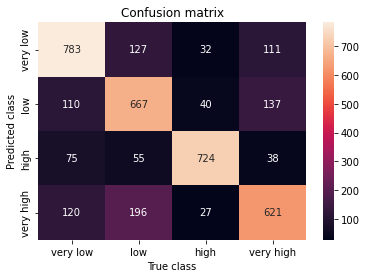

<Figure size 432x288 with 0 Axes>

Accuracy: 0.72
Micro precision: 0.72
Micro recall: 0.72
Micro F1-score: 0.72
Macro precision: 0.73
Macro recall: 0.72
Macro F1-score: 0.73
Weighted precision: 0.73
Weighted recall: 0.72
Weighted F1-score: 0.72
              precision    recall  f1-score   support

    very low       0.72      0.74      0.73      1053
         low       0.64      0.70      0.67       954
        high       0.88      0.81      0.84       892
   very high       0.68      0.64      0.66       964

    accuracy                           0.72      3863
   macro avg       0.73      0.72      0.73      3863
weighted avg       0.73      0.72      0.72      3863



In [34]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=y_test.cat.categories, yticklabels=y_pred.cat.categories)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix")
plt.show()
plt.savefig(os.path.join(p_dir, "confusion_matrix.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

print(classification_report(y_test, y_pred, target_names=cat_lbl))

# Grad-CAM class activation visualization

In [35]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def create_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    return superimposed_img

In [36]:
def cam_image(img_dir, id_video, last_cl, alpha=0.4):
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img_array = get_img_array(img_path, size=(120, 90))
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_cl)
    img = create_gradcam(img_path, heatmap, os.path.join(p_dir, "cam_{}.jpg".format(row["id_video"])), alpha)
    return img

In [37]:
p = re.compile("block\d+_conv\d+")
p2 = re.compile("block(\d+)_conv(\d+)")
conv_layers = dict()
for layer in model.layers:
    if p.match(layer.name):
        m = p2.search(layer.name)
        if m:
            conv_layers[m.group(1)] = m.group(2)

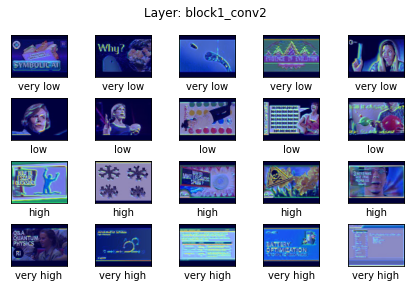

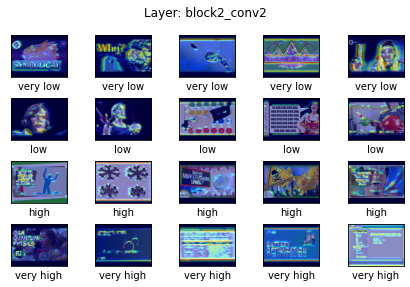

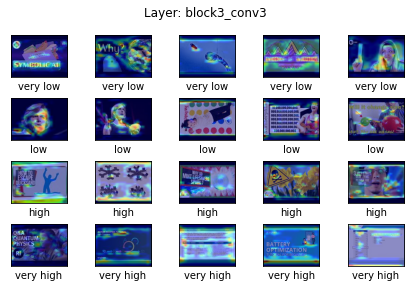

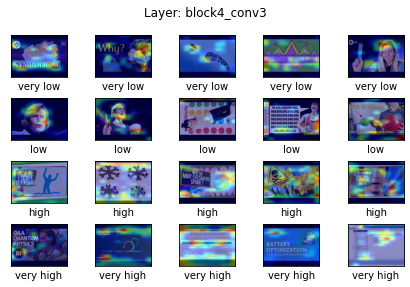

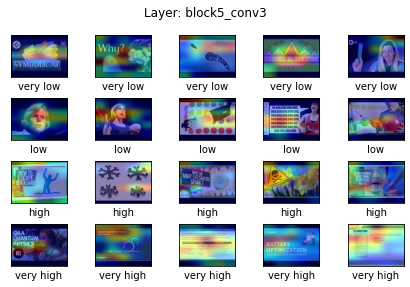

In [38]:
target_names = ["block{}_conv{}".format(k, v) for k, v in conv_layers.items()]
for layer in model.layers:
    if layer.name in target_names:        
        alpha = 0.8

        fig, axs = plt.subplots(len(cat_lbl), 5)
        i = 0
        for idx, row in s.iterrows():
            img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
            img = cam_image(img_dir, row["id_video"], layer.name, alpha)
            axs[i // 5, i % 5].imshow(img)
            axs[i // 5, i % 5].xaxis.set_ticklabels([])
            axs[i // 5, i % 5].xaxis.set_ticks([])
            axs[i // 5, i % 5].set_xlabel(row["qtl"])
            axs[i // 5, i % 5].yaxis.set_ticklabels([])
            axs[i // 5, i % 5].yaxis.set_ticks([])
            i += 1
        plt.suptitle("Layer: {}".format(layer.name))
        plt.tight_layout()        
        plt.show()
        fig.savefig(os.path.join(p_dir, "cam_sample_{}.jpg".format(layer.name)))